In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics  import roc_auc_score,accuracy_score

In [59]:
train=pd.read_csv(r'Train.csv')
test=pd.read_csv(r'Test.csv')

In [60]:
trainc=pd.concat([train,test])
trainc.describe(include='all')

,Offered_By,Category,Rating,Reviews,Size,Price,Content_Rating,Last_Updated_On,Release_Version,OS_Version_Required,Downloads
count,41292,41292,41292.000000,4.129200e+04,41292,41292,41292,41292,41292,41292,16516
unique,36772,51,NaN,NaN,703,129,6,2012,8052,37,18
top,ps_id-863,Education,NaN,NaN,Varies with device,Free,Everyone,May 06 2020,Varies with device,4.1 and up,"100,000+"
freq,52,3580,NaN,NaN,4830,38623,34810,1089,3880,10505,3158
mean,NaN,NaN,4.252862,1.929131e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.502586,1.827500e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.080000,1.470000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.360000,1.853000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.570000,2.197450e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#Offered_By
trainc['offer_test1']=trainc['Offered_By'].str.split('-').str[1]
trainc['offer_test2']=trainc['offer_test1'].str.len()
#trainc.Offered_By.head()
print(trainc['offer_test2'].value_counts())
trainc['offer_test1'].value_counts()

5    29920
4    10195
3     1073
2       94
1       10
Name: offer_test2, dtype: int64


863      52
1157     36
30264    34
1515     22
1713     22
         ..
10404     1
34226     1
35806     1
30342     1
3899      1
Name: offer_test1, Length: 36772, dtype: int64

In [5]:
trainc.Downloads.unique()

array(['100,000+', '5,000+', '10,000+', '10,000,000+', '50,000+',
       '1,000,000+', '5,000,000+', '500,000+', '1,000+', '1,000,000,000+',
       '50,000,000+', '100+', '100,000,000+', '500+', '10+', '50+',
       '500,000,000+', '5,000,000,000+', nan], dtype=object)

In [62]:
trainc['Downloads'] = trainc['Downloads'].map({'100,000+':8, '5,000+':5, '10,000+':6, '10,000,000+':12, '50,000+':7,
       '1,000,000+':10, '5,000,000+':11, '500,000+':9, '1,000+':4, '1,000,000,000+':16,
       '50,000,000+':13, '100+':2, '100,000,000+':14, '500+':3, '10+':0, '50+':1,
       '500,000,000+':15, '5,000,000,000+':17,np.nan:18}).astype('int64')

trainc.Downloads.unique()

array([ 8,  5,  6, 12,  7, 10, 11,  9,  4, 16, 13,  2, 14,  3,  0,  1, 15,
       17, 18])

In [7]:
print(trainc.Category.unique())
trainc.Category.value_counts()

['Finance' 'Music And Audio' 'Game Casual' 'Business' 'Medical'
 'Books And Reference' 'Tools' 'Game' 'Travel And Local' 'Family'
 'Game Simulation' 'Lifestyle' 'Comics' 'Education' 'Entertainment'
 'Game Action' 'Social' 'Sports' 'Photography' 'Game Word' 'Game Trivia'
 'Communication' 'News And Magazines' 'Game Board' 'House And Home'
 'Personalization' 'Game Puzzle' 'Productivity' 'Health And Fitness'
 'Shopping' 'Art And Design' 'Weather' 'Maps And Navigation' 'Dating'
 'Game Arcade' 'Game Role Playing' 'Game Educational' 'Video Players'
 'Game Strategy' 'Food And Drink' 'Game Sports' 'Auto And Vehicles'
 'Events' 'Game Adventure' 'Parenting' 'Libraries And Demo' 'Game Racing'
 'Game Card' 'Game Music' 'Game Casino' 'Beauty']


Education              3580
Tools                  3130
Entertainment          2232
Books And Reference    1812
Family                 1746
Finance                1687
Lifestyle              1682
Productivity           1464
Music And Audio        1342
Business               1327
Personalization        1151
Health And Fitness     1098
Game                   1094
News And Magazines     1058
Game Puzzle            1002
Photography             979
Communication           962
Travel And Local        947
Sports                  931
Shopping                900
Medical                 839
Game Casual             707
Social                  689
Game Arcade             669
Game Action             572
Food And Drink          566
Game Simulation         517
Game Card               496
Video Players           490
Game Educational        488
Maps And Navigation     485
Game Role Playing       421
Game Strategy           362
Game Racing             319
Game Adventure          315
Game Sports         

In [63]:
#Single Game  category
trainc['PCategory']=trainc.Category.replace('Game.*','Game',regex=True)

In [64]:
trainc.Price=trainc.Price.replace('Free',0)
#trainc.Price.replace(trainc[trainc['Price']!=0],1)
#trainc.Price='Free'
trainc.Price=trainc.Price.where(trainc.Price == 0, 1)
    

In [65]:
trainc.Rating=trainc.Rating.round()

In [66]:
trainc.Size=trainc.Size.str.replace('k','')

In [67]:
def convert_kb(x):
    if 'M' in x:
        return float(x.replace('M',''))*1024
    elif x=='Varies with device':
        return np.nan
    else:
        return float(x.replace(',',''))
trainc['SizeFactor']=trainc['Size'].apply(convert_kb)

#trainc.tail(20)
trainc.SizeFactor.dtypes

dtype('float64')

In [14]:
trainc.tail(20)

,Offered_By,Category,Rating,Reviews,Size,Price,Content_Rating,Last_Updated_On,Release_Version,OS_Version_Required,Downloads,offer_test1,offer_test2,PCategory,SizeFactor
24756,ps_id-15986,Family,4.0,120,32M,0,Everyone,Apr 17 2019,2.0,4.1 and up,18,15986,5,Family,32768.0
24757,ps_id-6724,Maps And Navigation,5.0,5130,6.9M,0,Everyone,May 05 2020,1.5.21,4.0.3 and up,18,6724,4,Maps And Navigation,7065.6
24758,ps_id-22395,Social,4.0,8982,101M,0,Everyone,Apr 09 2020,5.5.1,5.0 and up,18,22395,5,Social,103424.0
24759,ps_id-1700,Lifestyle,5.0,244,2.7M,0,Everyone,May 07 2020,3.5.3,4.0 and up,18,1700,4,Lifestyle,2764.8
24760,ps_id-20120,Family,4.0,250257,50M,0,Everyone,Dec 21 2017,1.1.5,2.3.3 and up,18,20120,5,Family,51200.0
24761,ps_id-35965,Game Educational,4.0,165,49M,0,Everyone,Mar 06 2020,1.0.4,4.1 and up,18,35965,5,Game,50176.0
24762,ps_id-1309,Books And Reference,5.0,2931,4.9M,0,Everyone,Mar 14 2020,2.12,4.0.3 and up,18,1309,4,Books And Reference,5017.6
24763,ps_id-26272,Game Card,4.0,584,58M,0,Teen,Apr 17 2020,1.5.11,4.1 and up,18,26272,5,Game,59392.0
24764,ps_id-21766,Finance,4.0,38805,4.7M,0,Everyone,Aug 23 2017,3.7.2,3.2 and up,18,21766,5,Finance,4812.8
24765,ps_id-1461,Education,4.0,932,8.6M,0,Everyone,Oct 07 2019,3.1,2.3.3 and up,18,1461,4,Education,8806.4


In [68]:
trainc.SizeFactor= trainc.groupby("Category").SizeFactor.transform(lambda x: x.fillna(x.mean()))

In [69]:
trainc['Last_Updated_Year']=trainc['Last_Updated_On'].str[-4:]

In [70]:
trainc.OS_Version_Required=trainc.OS_Version_Required.replace('Varies with device',0,regex=True)
trainc['OS_Version_Required']=trainc['OS_Version_Required'].str[:1].astype('float64')
trainc.OS_Version_Required=trainc.OS_Version_Required.replace(np.nan,0,regex=True)
trainc['OS_Version_Required']=trainc['OS_Version_Required'].astype('int64')

print(trainc.OS_Version_Required.unique())
trainc.OS_Version_Required.isna().sum()

[0 4 5 2 3 6 1 8 7]


0

In [71]:
trainc.Rating=trainc.Rating.astype('int64')
trainc.Price=trainc.Price.astype('int64')
trainc.SizeFactor=trainc.SizeFactor.round().astype('int64')
trainc.dtypes

Offered_By             object
Category               object
Rating                  int64
Reviews                 int64
Size                   object
Price                   int64
Content_Rating         object
Last_Updated_On        object
Release_Version        object
OS_Version_Required     int64
Downloads               int64
offer_test1            object
offer_test2             int64
PCategory              object
SizeFactor              int64
Last_Updated_Year      object
dtype: object

In [72]:
trainc2=trainc.copy()
trainc2=trainc2.drop(['Release_Version','Offered_By','Size','Last_Updated_On','Category','offer_test1'],1)
trainc2.columns
trainc2=trainc2[['offer_test2','Last_Updated_Year','PCategory','SizeFactor','Rating', 'Reviews', 'Price', 'Content_Rating'
       ,'OS_Version_Required','Downloads']]

trainc2.head()

,offer_test2,Last_Updated_Year,PCategory,SizeFactor,Rating,Reviews,Price,Content_Rating,OS_Version_Required,Downloads
0,5,2020,Finance,22582,4,1481,0,Everyone,0,8
1,5,2020,Music And Audio,10240,5,302,0,Everyone,4,5
2,5,2020,Game,27648,4,374,0,Everyone,4,6
3,5,2020,Business,17248,4,122058,0,Teen,0,12
4,5,2018,Medical,20497,5,358,1,Everyone,0,5


In [73]:
#trainc2.OS_Version_Required= trainc2.OS_Version_Required.replace(0.0,mode(trainc2.OS_Version_Required)))
trainc2.OS_Version_Required= trainc2.groupby(['PCategory','Last_Updated_Year']).OS_Version_Required.transform(lambda x: x.replace(0,x.mode()[0]))

print(trainc2.tail())
print(trainc2.dtypes)
print(trainc2.OS_Version_Required.unique())
print(trainc2.OS_Version_Required.isna().sum())
print(trainc2.OS_Version_Required.value_counts())

"""
trainc2_temp=trainc2.drop(['Downloads'],1)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()#instantiate
x_scaled2=scaler.fit_transform(trainc2_temp)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights='uniform', missing_values=np.nan)
new_array = imputer.fit_transform(x_scaled2)
# convert the nd-array returned in the step above to a Dataframe
trainc_test = pd.DataFrame(data=new_array, columns=trainc2_temp.columns)"""

       offer_test2 Last_Updated_Year  ... OS_Version_Required  Downloads
24771            5              2020  ...                   4         18
24772            4              2019  ...                   5         18
24773            4              2018  ...                   4         18
24774            4              2020  ...                   4         18
24775            4              2020  ...                   4         18

[5 rows x 10 columns]
offer_test2             int64
Last_Updated_Year      object
PCategory              object
SizeFactor              int64
Rating                  int64
Reviews                 int64
Price                   int64
Content_Rating         object
OS_Version_Required     int64
Downloads               int64
dtype: object
[4 5 2 3 6 1 8 7 0]
0
4    32717
2     3688
5     3335
3      692
6      409
1      279
7      137
8       28
0        7
Name: OS_Version_Required, dtype: int64


"\ntrainc2_temp=trainc2.drop(['Downloads'],1)\nfrom sklearn.preprocessing import StandardScaler\nscaler=StandardScaler()#instantiate\nx_scaled2=scaler.fit_transform(trainc2_temp)\n\nfrom sklearn.impute import KNNImputer\nimputer = KNNImputer(n_neighbors=3, weights='uniform', missing_values=np.nan)\nnew_array = imputer.fit_transform(x_scaled2)\n# convert the nd-array returned in the step above to a Dataframe\ntrainc_test = pd.DataFrame(data=new_array, columns=trainc2_temp.columns)"

In [74]:
trainc2.OS_Version_Required= trainc2.OS_Version_Required.transform(lambda x: x.replace(0,x.mode()[0]))
print(trainc2.OS_Version_Required.value_counts())

4    32724
2     3688
5     3335
3      692
6      409
1      279
7      137
8       28
Name: OS_Version_Required, dtype: int64


In [75]:
#temp=trainc2.copy()
trainc2.OS_Version_Required=trainc2.OS_Version_Required.astype('object')
trainc2.offer_test2=trainc2.offer_test2.astype('object')
trainc2.dtypes

offer_test2            object
Last_Updated_Year      object
PCategory              object
SizeFactor              int64
Rating                  int64
Reviews                 int64
Price                   int64
Content_Rating         object
OS_Version_Required    object
Downloads               int64
dtype: object

In [76]:
trainc2.OS_Version_Required.value_counts()

4    32724
2     3688
5     3335
3      692
6      409
1      279
7      137
8       28
Name: OS_Version_Required, dtype: int64

In [77]:
"""from sklearn.preprocessing import OneHotEncoder
OHE=OneHotEncoder(sparse=False)
OHE.fit_transform(trainc2['PCategory'])"""

trainc2=pd.get_dummies(trainc2)
trainc2.shape

(41292, 68)

In [78]:
#trainc[train.Size.str.contains('M')]
testc=trainc2.iloc[16516:,:]

print(test.shape)
print(testc.shape)

testc.Downloads.unique()

(24776, 10)
(24776, 68)


array([18])

In [79]:
testc2=testc.copy()
testc2=testc.drop('Downloads',1)
testc2.shape

(24776, 67)

In [80]:
trainc2=trainc2.iloc[:16516,:]
trainc2.shape

(16516, 68)

In [81]:
print(trainc2.Downloads.unique())
print(trainc2.Downloads.value_counts())
trainc2 = trainc2[trainc2.Downloads != 17]
print(trainc2.Downloads.value_counts())

[ 8  5  6 12  7 10 11  9  4 16 13  2 14  3  0  1 15 17]
8     3158
10    2707
6     2239
9     1360
12    1277
7     1243
4     1221
11     912
5      763
2      508
3      364
14     266
13     247
0       91
1       84
15      42
16      33
17       1
Name: Downloads, dtype: int64
8     3158
10    2707
6     2239
9     1360
12    1277
7     1243
4     1221
11     912
5      763
2      508
3      364
14     266
13     247
0       91
1       84
15      42
16      33
Name: Downloads, dtype: int64


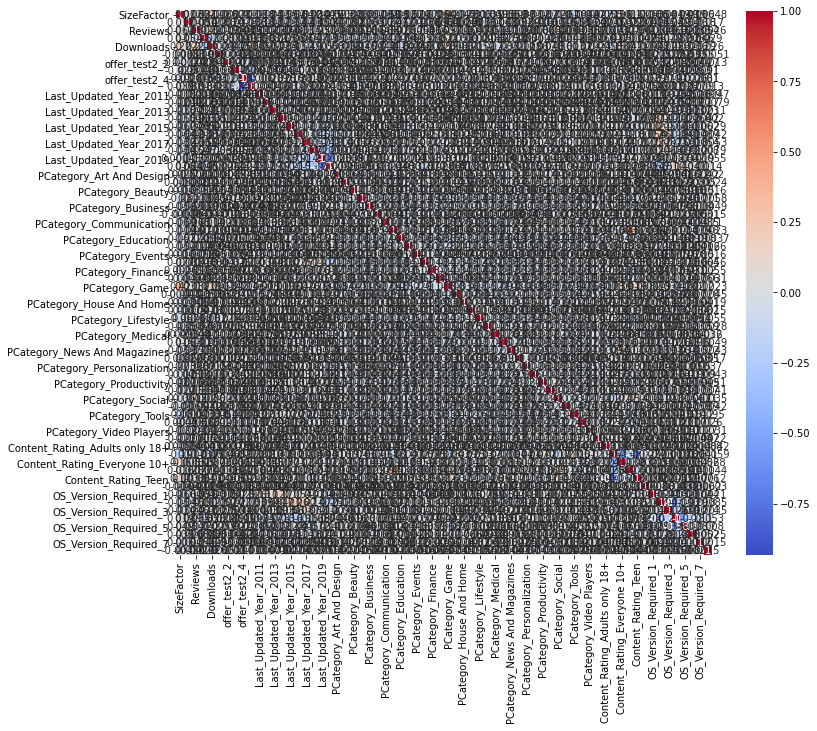

,SizeFactor,Rating,Reviews,Price,Downloads,offer_test2_1,offer_test2_2,offer_test2_3,offer_test2_4,offer_test2_5,Last_Updated_Year_2011,Last_Updated_Year_2012,Last_Updated_Year_2013,Last_Updated_Year_2014,Last_Updated_Year_2015,Last_Updated_Year_2016,Last_Updated_Year_2017,Last_Updated_Year_2018,Last_Updated_Year_2019,Last_Updated_Year_2020,PCategory_Art And Design,PCategory_Auto And Vehicles,PCategory_Beauty,PCategory_Books And Reference,PCategory_Business,PCategory_Comics,PCategory_Communication,PCategory_Dating,PCategory_Education,PCategory_Entertainment,PCategory_Events,PCategory_Family,PCategory_Finance,PCategory_Food And Drink,PCategory_Game,PCategory_Health And Fitness,PCategory_House And Home,PCategory_Libraries And Demo,PCategory_Lifestyle,PCategory_Maps And Navigation,PCategory_Medical,PCategory_Music And Audio,PCategory_News And Magazines,PCategory_Parenting,PCategory_Personalization,PCategory_Photography,PCategory_Productivity,PCategory_Shopping,PCategory_Social,PCategory_Sports,PCategory_Tools,PCategory_Travel And Local,PCategory_Video Players,PCategory_Weather,Content_Rating_Adults only 18+,Content_Rating_Everyone,Content_Rating_Everyone 10+,Content_Rating_Mature 17+,Content_Rating_Teen,Content_Rating_Unrated,OS_Version_Required_1,OS_Version_Required_2,OS_Version_Required_3,OS_Version_Required_4,OS_Version_Required_5,OS_Version_Required_6,OS_Version_Required_7,OS_Version_Required_8
SizeFactor,1.000000,0.012329,0.062163,0.030720,0.218435,-0.008515,-0.001708,-0.027533,-0.029982,0.039129,-0.017596,-0.024118,-0.032535,-0.054797,-0.061721,-0.064343,-0.032245,-0.033962,0.000451,0.075607,-0.024977,0.008199,-0.016066,-0.080212,-0.051787,-0.000312,-0.068755,-0.019405,-0.051769,-0.051553,-0.016128,0.076716,0.002620,-0.013823,0.424217,0.000426,-0.022674,-0.031284,-0.059882,-0.035130,-0.009521,0.014639,-0.058863,0.008558,-0.073350,-0.012331,-0.087283,-0.021637,-0.035825,-0.010138,-0.180416,0.004394,-0.027457,-0.027119,0.005472,-0.190919,0.158428,0.016439,0.127410,-0.006271,-0.066498,-0.053829,-0.033542,0.018943,0.048974,0.038627,0.006005,-0.004841
Rating,0.012329,1.000000,0.008039,0.054295,-0.022219,0.008302,0.002421,0.029708,0.027521,-0.037574,-0.017886,-0.017759,-0.022437,-0.028978,-0.032013,-0.041687,-0.043469,-0.044782,-0.017025,0.084070,0.007178,-0.008204,-0.008148,0.121252,-0.064742,-0.007577,-0.026608,-0.046122,0.072128,-0.021473,-0.003748,-0.033183,-0.068931,-0.006444,0.030575,-0.000232,-0.004845,-0.007492,0.007550,-0.032854,-0.000482,0.063287,-0.034599,0.022408,0.039035,-0.003627,-0.016355,-0.014978,-0.001483,-0.006533,-0.012661,-0.056393,-0.024251,-0.006951,0.000452,0.010035,-0.005470,-0.023266,0.003709,-0.004154,-0.018039,-0.045220,-0.023864,0.088786,-0.053554,-0.026309,-0.017935,-0.017485
Reviews,0.062163,0.008039,1.000000,-0.024734,0.209604,-0.001886,-0.002774,-0.004843,-0.007466,0.009284,-0.001708,-0.002741,-0.003744,-0.006643,-0.008489,-0.012945,-0.015345,-0.023443,0.052645,-0.024398,-0.006059,-0.008115,-0.005415,-0.018223,-0.015767,-0.004454,0.064879,-0.007007,-0.028152,-0.016621,-0.005755,0.004565,-0.015814,-0.009033,0.037087,-0.011234,-0.005444,-0.004744,-0.017923,-0.005490,-0.013693,-0.010722,-0.012552,-0.005843,-0.008696,0.018086,-0.006804,0.003791,0.122723,-0.009338,-0.007285,-0.005566,0.003662,-0.001713,-0.001356,-0.072725,0.032297,0.007743,0.065609,-0.001088,-0.006363,-0.019497,-0.006333,0.034977,-0.022444,-0.008320,-0.005363,-0.002644
Price,0.030720,0.054295,-0.024734,1.000000,-0.231737,-0.005008,0.007957,-0.013663,-0.009333,0.013148,0.009593,0.000816,0.020646,0.065393,0.085714,0.087901,0.065109,0.046983,-0.012736,-0.094662,-0.012604,-0.011704,-0.015184,-0.012891,-0.029083,-0.014182,-0.010995,-0.016552,-0.009563,-0.049070,-0.015459,0.018180,-0.035114,-0.019963,0.110346,-0.005297,-0.018782,-0.001834,-0.020819,-0.008458,0.086726,-0.025192,-0.032601,-0.008452,0.069776,-0.011645,0.000281,-0.038556,-0.020351,-0.004224,0.003323,-0.018036,-0.019869,-0.006529,-0.004089,-0.016785,0.049584,-0.010365,-0.004651,-

In [56]:
#Finding Correlation and droping features
cor=trainc2.corr()
import matplotlib.pyplot as plt
import seaborn as sns
#Heatmap for visualisation of correlation analysis
plt.figure(figsize=(12,10))
sns.heatmap(cor,annot=True,cmap='coolwarm')
#when we write annot= True , it shows the values .
plt.show()
cor.to_csv('Correlation.csv', index=True)
cor

In [82]:
train_x= trainc2.copy()
train_y= trainc2.copy()

train_x=train_x.drop('Downloads',1)
train_y=train_y.drop(train_x.columns,1)
print(train_x.columns)
print(train_y.columns)
print(train_x.shape)
print(train_y.shape)
print(train_x.dtypes)
print(train_y.dtypes)

Index(['SizeFactor', 'Rating', 'Reviews', 'Price', 'offer_test2_1',
       'offer_test2_2', 'offer_test2_3', 'offer_test2_4', 'offer_test2_5',
       'Last_Updated_Year_2011', 'Last_Updated_Year_2012',
       'Last_Updated_Year_2013', 'Last_Updated_Year_2014',
       'Last_Updated_Year_2015', 'Last_Updated_Year_2016',
       'Last_Updated_Year_2017', 'Last_Updated_Year_2018',
       'Last_Updated_Year_2019', 'Last_Updated_Year_2020',
       'PCategory_Art And Design', 'PCategory_Auto And Vehicles',
       'PCategory_Beauty', 'PCategory_Books And Reference',
       'PCategory_Business', 'PCategory_Comics', 'PCategory_Communication',
       'PCategory_Dating', 'PCategory_Education', 'PCategory_Entertainment',
       'PCategory_Events', 'PCategory_Family', 'PCategory_Finance',
       'PCategory_Food And Drink', 'PCategory_Game',
       'PCategory_Health And Fitness', 'PCategory_House And Home',
       'PCategory_Libraries And Demo', 'PCategory_Lifestyle',
       'PCategory_Maps And Naviga

In [83]:
test_x=testc2.copy()
test_x.shape

(24776, 67)

In [84]:
print(train_x.shape)
print(test_x.shape)
train_x=train_x.drop(['Last_Updated_Year_2019','PCategory_Game','Content_Rating_Everyone','offer_test2_5','OS_Version_Required_4'],1)
test_x=test_x.drop(['Last_Updated_Year_2019','PCategory_Game','Content_Rating_Everyone','offer_test2_5','OS_Version_Required_4'],1)

print(train_x.shape)
print(test_x.shape)

(16515, 67)
(24776, 67)
(16515, 62)
(24776, 62)


In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_x.values, i) for i in range(train_x.shape[1])]
vif["features"] = train_x.columns
vif.round(1)
#vif.round(1).to_csv(r'VIF.csv')

,VIF Factor,features
0,2.6,SizeFactor
1,10.8,Rating
2,1.0,Reviews
3,1.1,Price
4,1.0,offer_test2_1
...,...,...
57,1.1,OS_Version_Required_3
58,1.1,OS_Version_Required_5
59,1.0,OS_Version_Required_6
60,1.0,OS_Version_Required_7


Text(0, 0.5, 'cumulative explained variance')

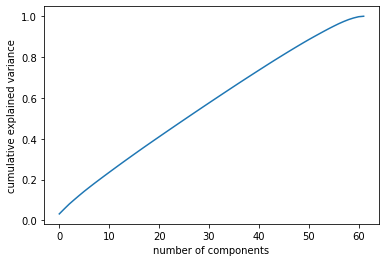

In [105]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()#instantiate
x_scaled=scaler.fit_transform(train_x)
from sklearn.decomposition import PCA
pca = PCA().fit(x_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca.fit(x_scaled)
print(np.cumsum(pca.explained_variance_ratio_))

[0.0321265  0.05672876 0.08050773 0.10167786 0.12245444 0.14266534
 0.16180615 0.18071379 0.19901934 0.21721366 0.23509844 0.25291604
 0.2706716  0.28833961 0.30575519 0.3230799  0.34034146 0.35749559
 0.37444433 0.39125694 0.40800722 0.4247344  0.44143085 0.45803828
 0.47460037 0.49111118 0.50760097 0.52395956 0.54024459 0.55650062
 0.57272427 0.58882273 0.60486969 0.6207821  0.63666993 0.65244413
 0.66817247 0.6838252  0.6994463  0.71491199]


In [88]:
# splitting the data into training and test set for each cluster one by one
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=1 / 3, random_state=355)

In [89]:
clf = RandomForestClassifier()
#Parameters for tuning
param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}
                               
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,  verbose=3)
#finding the best parameters
grid.fit(train_x, train_y)


#extracting the best parameters
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
max_features = grid.best_params_['max_features']
n_estimators = grid.best_params_['n_estimators']

#creating a new model with the best parameters
clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                              max_depth=max_depth, max_features=max_features)
# training the mew model
clf.fit(train_x, train_y)

"""
rf_pred=clf.predict()
rf_score=roc_auc_score(y_test,rf_pred)
rf_score
"""

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.320, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.201, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.325, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.333, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.311, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.312, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.311, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.304, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.307, total=   0.3s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.309, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.312, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.311, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.316, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.319, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.309, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.312, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.311, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.318, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.317, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.307, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.312, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.298, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.324, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.277, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.310, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.311, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.311, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.281, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.319, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.308, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.312, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.311, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.313, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.320, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.304, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.312, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.317, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.318, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.315, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.309, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.323, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.223, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.325, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.327, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.313, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.312, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.315, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.320, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.325, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.319, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.316, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.315, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.320, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.322, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.311, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.313, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.315, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.319, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.322, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.311, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.318, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.306, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.321, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.324, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.309, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.313, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.312, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.316, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.320, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.310, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.318, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.312, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.319, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.319, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.309, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.314, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.313, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.316, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.318, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.306, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.268, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.276, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.308, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.247, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.276, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.271, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.295, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.282, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.299, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.289, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.290, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.278, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.295, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.298, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.289, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.296, total=   0.8s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.290, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.296, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.285, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.291, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.223, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.252, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.262, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.287, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.266, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.291, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.260, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.268, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.285, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.281, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.268, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.212, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.296, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.272, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.292, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.290, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.267, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.289, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.274, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.263, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.299, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.299, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.304, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.319, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.285, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.299, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.306, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.311, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.307, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.294, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.309, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.308, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.308, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.306, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.293, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.304, total=   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.300, total=   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.312, total=   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.295, total=   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.307, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.348, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.285, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.233, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.295, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.299, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.290, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.293, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.298, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.285, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.265, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.295, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.292, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.304, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.310, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.299, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.293, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.287, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.300, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.281, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.299, total=   0.8s


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


'\nrf_pred=clf.predict()\nrf_score=roc_auc_score(y_test,rf_pred)\nrf_score\n'

In [90]:
print(criterion, max_depth, max_features, n_estimators)
predictions_proba = clf.predict_proba(test_x)
#a=np.round(predictions_proba,1)
predictions_proba=pd.DataFrame(predictions_proba)
predictions_proba.to_csv(r'Results_rf.csv')

gini 3 auto 50


In [91]:
from sklearn.metrics import accuracy_score
rf_pred=clf.predict(x_test)
accuracy_score(y_test, rf_pred)

0.31498637602179835

In [107]:
train_x.to_csv('train_x.csv')
train_y.to_csv('train_y.csv')
test_x.to_csv('test_x.csv')

In [ ]:
 xgb = XGBClassifier(objective='multi:softprob')
# initializing with different combination of parameters
param_grid_xgboost = {
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [3, 5, 10, 20],
                'n_estimators': [10, 50, 100, 200]
            }
# Creating an object of the Grid Search class
grid= GridSearchCV(xgb,param_grid_xgboost, verbose=3,cv=5)
# finding the best parameters
grid.fit(train_x, train_y)

# extracting the best parameters
learning_rate = grid.best_params_['learning_rate']
max_depth = grid.best_params_['max_depth']
n_estimators = grid.best_params_['n_estimators']

# creating a new model with the best parameters
xgb = XGBClassifier(objective='multi:softprob',learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
# training the mew model
xgb.fit(train_x, train_y) 

print(learning_rate, max_depth, n_estimators)

predictions_proba = xgb.predict_proba(test_x)
a=np.round(predictions_proba,2)
a=pd.DataFrame(a)
a.to_csv('Results_xgb.csv')

In [ ]:
#xgb = XGBClassifier(objective='multi:softprob',learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
xgb = XGBClassifier(objective='multi:softprob',learning_rate=0.1, max_depth=8, n_estimators=30)
xgb.fit(x_train, y_train)
prediction_xgboost = xgb.predict(x_test)
#results = confusion_matrix(y_test, prediction_xgboost)
#print('Confusion Matrix :')
#print(results)
print('Accuracy Score :', accuracy_score(y_test, prediction_xgboost))
print('Report : ')
#print(classification_report(y_test, prediction_xgboost))
predictions_proba = xgb.predict_proba(test_x)
#a=np.round(predictions_proba,2)
a=pd.DataFrame(predictions_proba)
a.to_csv(r'C:\Users\Ankz\Downloads\PlayStoreApps-ParticipantsData\PlayStoreApps-ParticipantsData\Results_xgb.csv')

Accuracy Score : 0.553133514986376
Report : 


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier(objective='multi:softprob')
# initializing with different combination of parameters
param_grid_xgboost = {
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [3, 5, 10, 20],
                'n_estimators': [10, 50, 100, 200]
            }
# Creating an object of the Grid Search class
grid= RandomizedSearchCV(xgb,param_grid_xgboost, verbose=3,cv=5)
# finding the best parameters
grid.fit(train_x, train_y)

# extracting the best parameters
learning_rate = grid.best_params_['learning_rate']
max_depth = grid.best_params_['max_depth']
n_estimators = grid.best_params_['n_estimators']

# creating a new model with the best parameters
xgb = XGBClassifier(objective='multi:softprob',learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
# training the mew model
xgb.fit(train_x, train_y) 

print(learning_rate, max_depth, n_estimators)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] n_estimators=100, max_depth=20, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=20, learning_rate=0.001, score=0.544, total= 1.3min
[CV] n_estimators=100, max_depth=20, learning_rate=0.001 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=100, max_depth=20, learning_rate=0.001, score=0.564, total= 1.3min
[CV] n_estimators=100, max_depth=20, learning_rate=0.001 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV]  n_estimators=100, max_depth=20, learning_rate=0.001, score=0.549, total= 1.2min
[CV] n_estimators=100, max_depth=20, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=20, learning_rate=0.001, score=0.553, total= 1.4min
[CV] n_estimators=100, max_depth=20, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=20, learning_rate=0.001, score=0.551, total= 1.5min
[CV] n_estimators=100, max_depth=10, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=10, learning_rate=0.001, score=0.543, total= 1.2min
[CV] n_estimators=100, max_depth=10, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=10, learning_rate=0.001, score=0.569, total= 1.3min
[CV] n_estimators=100, max_depth=10, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=10, learning_rate=0.001, score=0.554, total= 1.3min
[CV] n_estimators=100, max_depth=10, learning_rate=0.001 .............
[CV]  n_estimators=100, max_depth=10, learning_rate=0.001,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 36.2min finished


0.1 10 50


3


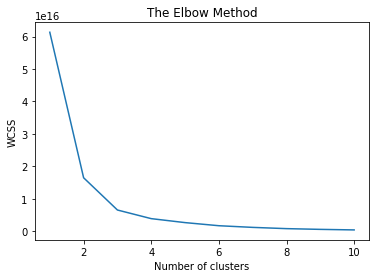

In [94]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!pip install kneed
from kneed import KneeLocator

wcss=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)  # initializing the KMeans object
    kmeans.fit(train_x)  # fitting the data to the KMeans Algorithm
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)  # creating the graph between WCSS and the number of clusters
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.show()
#plt.savefig(r'C:\Users\Ankz\Downloads\PlayStoreApps-ParticipantsData\PlayStoreApps-ParticipantsData\preprocessing_data\K-Means_Elbow.PNG')  # saving the elbow plot locally
# finding the value of the optimum cluster programmatically
kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
print(kn.knee)

In [95]:
train_xkmeans=train_x.copy()
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans=kmeans.fit_predict(train_xkmeans) #  divide data into clusters
train_xkmeans['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
train_xkmeans.Cluster.value_counts()

1    16379
0      126
2       10
Name: Cluster, dtype: int64

In [96]:
train_xkmeans['Downloads']= train_y.Downloads


In [97]:
print(train_xkmeans.shape)
print(train_xkmeans.describe())
train_xkmeans.Downloads.value_counts()

(16515, 64)
          SizeFactor        Rating  ...       Cluster     Downloads
count   16515.000000  16515.000000  ...  16515.000000  16515.000000
mean    23344.200484      4.232153  ...      0.992976      7.935150
std     22728.836554      0.615094  ...      0.090477      2.855037
min         5.000000      1.000000  ...      0.000000      0.000000
25%      6758.000000      4.000000  ...      1.000000      6.000000
50%     15928.000000      4.000000  ...      1.000000      8.000000
75%     31744.000000      5.000000  ...      1.000000     10.000000
max    118784.000000      5.000000  ...      2.000000     16.000000

[8 rows x 64 columns]


8     3158
10    2707
6     2239
9     1360
12    1277
7     1243
4     1221
11     912
5      763
2      508
3      364
14     266
13     247
0       91
1       84
15      42
16      33
Name: Downloads, dtype: int64

In [98]:
train_xkmeans=train_xkmeans[train_xkmeans['Cluster']==1]
train_xkmeans=train_xkmeans.drop('Cluster',1)

print(train_xkmeans.shape)
print(train_x.shape)


(16379, 63)
(16515, 62)


In [99]:
#ab=train_xkmeans.copy()
train_xkmeans=train_xkmeans[train_xkmeans['Downloads']!=15]
train_xkmeans=train_xkmeans[train_xkmeans['Downloads']!=16]
train_xkmeans.Downloads.value_counts()

8     3158
10    2707
6     2239
9     1360
12    1277
7     1243
4     1221
11     912
5      763
2      508
3      364
13     241
14     187
0       91
1       84
Name: Downloads, dtype: int64

In [100]:
train_xkmeans1=train_xkmeans.copy()
train_ykmeans1=train_xkmeans.copy()
train_xkmeans1=train_xkmeans1.drop('Downloads',1)
train_ykmeans1=train_ykmeans1.drop(train_xkmeans1.columns,1)
print(train_xkmeans1.shape)
train_ykmeans1.shape


(16355, 62)


(16355, 1)

In [101]:
clf = RandomForestClassifier()
#Parameters for tuning
param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}
                               
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,  verbose=3)
#finding the best parameters
grid.fit(train_xkmeans1, train_ykmeans1)


#extracting the best parameters
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
max_features = grid.best_params_['max_features']
n_estimators = grid.best_params_['n_estimators']

#creating a new model with the best parameters
clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                              max_depth=max_depth, max_features=max_features)
# training the mew model
clf.fit(train_xkmeans1, train_ykmeans1)

"""
rf_pred=clf.predict()
rf_score=roc_auc_score(y_test,rf_pred)
rf_score
"""

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.316, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.365, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.317, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.272, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.319, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.315, total=   0.3s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.312, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.319, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.268, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.306, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.315, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.314, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.320, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.322, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.311, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.315, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.314, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.321, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.320, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=130, score=0.312, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.275, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.315, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.319, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.282, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=10, score=0.312, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.290, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.314, total=   0.3s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.319, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.284, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=50, score=0.300, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.315, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.314, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.322, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.320, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=100, score=0.284, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.315, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.313, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.321, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.320, total=   0.6s
[CV] criterion=gini, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=2, max_features=log2, n_estimators=130, score=0.312, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.322, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.325, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.323, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.331, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.324, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.322, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.317, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.323, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.331, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.312, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.317, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.318, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.327, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.323, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.315, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.315, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.319, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.323, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.327, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.318, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.315, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.206, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.202, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.321, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.314, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.315, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.315, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.322, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.322, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=50 .


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.308, total=   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.315, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.315, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.321, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.320, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.313, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.315, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.315, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.322, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.321, total=   0.7s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=130, score=0.310, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.283, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.296, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.305, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.194, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=10, score=0.299, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.291, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.276, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.290, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.291, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=50, score=0.304, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.291, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.291, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.285, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.293, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=100, score=0.280, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.296, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.280, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.294, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.298, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.294, total=   0.8s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.300, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.264, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.193, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.244, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.210, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.295, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.274, total=   0.2s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.289, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.269, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.277, total=   0.3s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.250, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.276, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.293, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.297, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.290, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.286, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.268, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.276, total=   0.6s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.284, total=   0.7s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=130, score=0.285, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.337, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.296, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.334, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.346, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.298, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.305, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.310, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.312, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.311, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.301, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.305, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.309, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.300, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.294, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.311, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.309, total=   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.302, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.313, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.308, total=   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=130, score=0.306, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.268, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.290, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.300, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.288, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.252, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.302, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.291, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.296, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.292, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.272, total=   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.298, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.303, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.307, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.297, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.296, total=   0.6s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.307, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.291, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.302, total=   0.8s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.294, total=   0.7s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.297, total=   0.8s


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


'\nrf_pred=clf.predict()\nrf_score=roc_auc_score(y_test,rf_pred)\nrf_score\n'

In [102]:
print(criterion, max_depth, max_features, n_estimators)
predictions_proba = clf.predict_proba(test_x)
#a=np.round(predictions_proba,1)
predictions_proba=pd.DataFrame(predictions_proba)
predictions_proba.to_csv(r'Results_rf.csv')


gini 3 auto 10


In [103]:
train_ykmeans1.Downloads.value_counts()

8     3158
10    2707
6     2239
9     1360
12    1277
7     1243
4     1221
11     912
5      763
2      508
3      364
13     241
14     187
0       91
1       84
Name: Downloads, dtype: int64

In [ ]:
#xgb = XGBClassifier(objective='multi:softprob',learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
xgb = XGBClassifier(objective='multi:softprob',learning_rate=0.1, max_depth=7, n_estimators=35)
xgb.fit(train_xkmeans1, train_ykmeans1)
prediction_xgboost = xgb.predict(x_test)
#results = confusion_matrix(y_test, prediction_xgboost)
#print('Confusion Matrix :')
#print(results)
print('Accuracy Score :', accuracy_score(y_test, prediction_xgboost))
print('Report : ')
#print(classification_report(y_test, prediction_xgboost))
predictions_proba = xgb.predict_proba(test_x)
#a=np.round(predictions_proba,2)
a=pd.DataFrame(predictions_proba)
a.to_csv(r'C:\Users\Ankz\Downloads\PlayStoreApps-ParticipantsData\PlayStoreApps-ParticipantsData\Results_xgb.csv')

Accuracy Score : 0.6274296094459583
Report : 
